### Import Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import random
from matplotlib import pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.monitor import Monitor
import torch as th


In [3]:
%load_ext autoreload
%autoreload 2
from environment import Environment
from resource_allocation import *

### Define Environment

In [4]:
# Use the Solarize Light style globally
plt.style.use("Solarize_Light2")

# Set global parameters for black axes, labels, and grid
plt.rcParams['grid.color'] = 'white'               # Grid color
plt.rcParams['grid.linestyle'] = '--'              # Grid linestyle
plt.rcParams['grid.alpha'] = 0.7                   # Grid transparency
plt.rcParams['axes.edgecolor'] = 'black'           # Axis border color
plt.rcParams['axes.labelcolor'] = 'black'          # Axis label color
plt.rcParams['xtick.color'] = 'black'              # X-axis tick color
plt.rcParams['ytick.color'] = 'black'              # Y-axis tick color
plt.rcParams['text.color'] = 'black'               # Default text color, affects title color

In [5]:
import gymnasium as gym  # Correct import for Gymnasium
from gymnasium import spaces
import numpy as np

class QoEEnvironment(gym.Env):
    """
    Custom environment for QoE simulation compatible with Gymnasium.
    """
    def __init__(self, run_for=5000, cpu_capacity=5.5, seed=4022, num_area = 1):
        super(QoEEnvironment, self).__init__()
        
        # Initialize the environment parameters
        self.run_for = run_for
        self.cpu_capacity = cpu_capacity
        self.num_area = num_area
        self.env = Environment(run_for, cpu_capacity, seed)
        self.env.run_for = run_for
        self.seed_value = seed  # Save seed for reproducibility
        
        # Seed NumPy and random
        self.np_random, _ = gym.utils.seeding.np_random(seed)
        np.random.seed(seed)  
        random.seed(self.seed_value)  # Seed Python's random        
              
        self.history_length = 5 # Number of previous timesteps to include in the observation

        # Define action and observation spaces
        # For example, the observation includes 4 features per timestep (QoE, users, attack intensity, CPU allocation)
        self.features_per_timestep = 4
        self.observation_space = spaces.Box(
            low=0, high=1, 
            shape=(self.num_area, self.history_length, self.features_per_timestep,), 
            # shape=(self.num_area * self.history_length * self.features_per_timestep,), 
            dtype=np.float32)
        
        # self.action_space = spaces.MultiDiscrete([11]*num_area) 
        self.action_space = spaces.Discrete(11**num_area) 
        # Initialize history
        self.history = np.zeros(
            (num_area, self.history_length, self.features_per_timestep), 
            dtype=np.float32)

        # Initialize simulation-specific variables
        self.current_timestep = 0
        
        #? Record Previous States
        self.prev_atk_state = ""
        self.prev_cpu_decision = [cpu_capacity]*num_area
        
        self.reset(seed)

    def reset(self, seed=None,):
        """
        Reset the environment to an initial state and return the initial observation.
        """
        super().reset(seed=seed)
        if seed is not None:
            self.seed_value = seed
            self.np_random, _ = gym.utils.seeding.np_random(seed)
            np.random.seed(seed)        
            random.seed(self.seed_value)
            
        self.env = Environment(self.run_for, self.cpu_capacity, seed)
        self.current_timestep = 0        
        self.env.initialize_agent(num_area=self.num_area, num_streamers=6, num_attackers=1)

        # Reset state
        self.history = np.zeros(
            (self.num_area, self.history_length, self.features_per_timestep), 
            dtype=np.float32)
        return self.history, {}  # Return initial observation and info

    def step(self, action):
        """
        Decide Action => Start next timestep => Get the QoE => Store it in history.
        Updates only every H timesteps.
        """
        H = 20  # Update interval
        
        # Set Default Values
        # video_cpus = [self.history[area_idx, -1, 2] * self.cpu_capacity for area_idx in range(self.num_area)]
        video_cpus = self.prev_cpu_decision
        
        if self.current_timestep%H==0:
        # if True:
            for area_idx in range(self.num_area):
                area = self.env.area_dict[area_idx]["area"]
                
                # video_cpu[area_idx] = 0.5+action[area_idx]*0.5 
                
                decoded_action = np.unravel_index(action, [11] * self.num_area)
                video_cpus[area_idx] = 0.5+decoded_action[area_idx]*0.5 
                video_cpus[area_idx] = 3.5
                # video_cpus[area_idx] = resource_decision_baseline({"ori_intensity": int(self.history[area_idx, -1, 0]*2000), "n_streamers": int(self.history[area_idx, -1, 1]*6)}) if self.current_timestep > 0 else video_cpus[area_idx]
                # video_cpus[area_idx] = resource_decision_optimal({"atk_type": self.prev_atk_state, "ori_intensity": int(self.history[area_idx, -1, 0]*2000), "n_streamers": int(self.history[area_idx, -1, 1]*6)}) if self.current_timestep > 0 else video_cpus[area_idx]
                
                area.server.cpu_allocated = video_cpus[area_idx]
                area.ids.cpu_allocated = 6.0 - video_cpus[area_idx]
                

        # Simulate one timestep
        global_states, atk_config = self.env.start_new_timestep() #Start New Timestep and gather new_state information
        self.prev_atk_state = atk_config.value['name'] #TODO: Change this to List
        self.current_timestep += 1
        area_qoe = self.env.calculate_qoe()
        self.prev_cpu_decision = video_cpus
        
        # Update QoE and normalize CPU decisions in states #? # new_state[2] = video_cpu/5.5; new_state[3] = self.env.qoe_list[-1]
        for area_idx in range(self.num_area):
            #Update states
            global_states[area_idx][2] = video_cpus[area_idx] / self.cpu_capacity  # Normalize video CPU
            global_states[area_idx][3] = area_qoe[area_idx]  # QoE for the area    

            # Update history
            self.history[area_idx] = np.roll(self.history[area_idx], shift=-1, axis=0)   
            self.history[area_idx][-1] = global_states[area_idx][:]
        
        reward = self.calculate_reward() #if self.current_timestep%H ==0 else 0

        # Check if the episode is done
        done = self.current_timestep >= self.env.run_for - 1
        truncated = False  # Not using truncated episodes here

        # Additional info
        info = {"mean_qoe": np.mean(self.env.global_qoe_list)} if done else {"mean_qoe": self.env.global_qoe_list[-1]}
        return self.history, reward, done, truncated, info
    


    def calculate_reward(self):
        """
        Calculate the reward for the given state.
        """
        if len(self.env.global_qoe_list) > 1:
            qoe = self.env.global_qoe_list[-1]
            # return self.env.global_qoe_list[-1] - self.env.global_qoe_list[-2]+0.2
            return self.env.global_qoe_list[-1] - 0.8
            # return self.env.global_qoe_list[-1]
            if qoe< 0.8:
                reward = self.env.global_qoe_list[-1] - self.env.global_qoe_list[-2]-0.2  # Higher rewards for higher QoE values
            else:
                reward = qoe
            return reward
        return 0

    def render(self, mode="human"):
        """
        Render the environment (optional).
        """
        print(f"Timestep: {self.current_timestep}, State: {self.history[-1]}")

    def close(self):
        """
        Cleanup the environment (optional).
        """
        print("Environment closed.")


### Check The Environment

In [6]:
run_for = 10_000
env = QoEEnvironment(run_for=run_for, cpu_capacity=5.5, seed=4022, num_area=3)
obs, _ = env.reset(seed=4022)
# check_env(env)  # This will raise exceptions if there are API compliance issues
for timestep in range(100):
    action = env.action_space.sample()  # Sample a random action
    obs, reward, done, truncated, info = env.step(action)  # Perform the step
    if done:
        print("Episode finished!")
        break  # Exit if the episode ends

env.history

array([[[0.355     , 0.5       , 0.6363636 , 0.96994555],
        [0.365     , 0.5       , 0.6363636 , 0.96994555],
        [0.353     , 0.5       , 0.6363636 , 0.96994555],
        [0.368     , 0.5       , 0.6363636 , 0.96994555],
        [0.382     , 0.33333334, 0.6363636 , 0.9699994 ]],

       [[0.        , 0.5       , 0.6363636 , 0.96994555],
        [0.        , 0.5       , 0.6363636 , 0.96994555],
        [0.        , 0.5       , 0.6363636 , 0.96994555],
        [0.        , 0.33333334, 0.6363636 , 0.9699994 ],
        [0.        , 0.33333334, 0.6363636 , 0.9699994 ]],

       [[0.25      , 0.5       , 0.6363636 , 0.96994555],
        [0.2195    , 0.5       , 0.6363636 , 0.96994555],
        [0.        , 0.5       , 0.6363636 , 0.96994555],
        [0.        , 0.5       , 0.6363636 , 0.96994555],
        [0.        , 0.5       , 0.6363636 , 0.96994555]]], dtype=float32)

### Initialize Training

In [7]:
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.callbacks import EvalCallback
from wandb.integration.sb3 import WandbCallback


class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-10:])
              if self.verbose > 0:
                print("Num timesteps: {} QoE: {}".format(self.num_timesteps, y[-1]))
                print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print("Saving new best model to {}".format(self.save_path))
                  self.model.save(self.save_path)

        return True
    
    
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=3)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()




/Users/shehvincent/anaconda3/envs/edge_computing/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [8]:
# from stable_baselines3 import DQN, PPO
# from sb3_contrib import RecurrentPPO

# # from sb3_contrib import QRDQN
# # Create a profiler instance

# env=QoEEnvironment(run_for=run_for, cpu_capacity=5.5, num_area=3)
# env = Monitor(env, log_dir)

# policy_kwargs = dict(activation_fn=th.nn.ReLU,
#                      net_arch=[128, 256, 128, 64, 64])
# # Initialize the DQN agent
# model = DQN(
#     "MlpPolicy",  # Use a standard multi-layer perceptron policy
#     env,
#     learning_rate=0.001,
#     buffer_size=50000,
#     learning_starts=1000,
#     batch_size=64,
#     gamma=0.99,  # Discount factor for future rewards
#     target_update_interval=500,
#     train_freq=4,  # Train every 4 environment steps
#     verbose=1,
#     tensorboard_log="./dqn_logs/",
#     max_grad_norm=10,
#     seed=4022,
#     policy_kwargs=policy_kwargs,
# )
# # Train the agent
# model.learn(total_timesteps=1_000_000)

# # Save the trained model
# # model.save("dqn_qoe_env")


In [15]:
import wandb
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from sb3_contrib import RecurrentPPO
import torch
# Config dictionaries
config = {
    "project_name": "ids-project",
    "entity_name": "vincent",
    "learning_rate": 0.0005,
    "batch_size": 64,
    "gamma": 0.99,
    "n_steps": 256,
    "total_timesteps": 1_000_000,
    "run_for": 1000,  # Example parameter for QoEEnvironment
    "cpu_capacity": 5.5,
    "num_area": 3,
    "log_dir": "./tb_logs/"
}


def select_model(model_type="DQN", env):
    policy_config = {
        "MlpLstmPolicy": {
            "net_arch": [64, 64],
            "lstm_hidden_size": 256,
        },
        "PPO": {
            "net_arch": [128, 128],
        },
        "DQN": {
            "net_arch": [256, 256],
            "buffer_size": 50_000,
            "learning_starts": 1_000,
            "target_update_interval": 500,
            "train_freq": 4,
            "max_grad_norm": 10,
            "seed": 4022,
        }
    }    
    
    if model_type == "RecurrentPPO":
        model = RecurrentPPO(
            "MlpLstmPolicy",
            env,
            learning_rate=config["learning_rate"],
            batch_size=config["batch_size"],
            n_steps=config["n_steps"],
            gamma=config["gamma"],
            verbose=1,
            tensorboard_log=config["log_dir"],
            policy_kwargs=dict(
                net_arch=policy_config["MlpLstmPolicy"]["net_arch"],
                lstm_hidden_size=policy_config["MlpLstmPolicy"]["lstm_hidden_size"],
            ),
            device='cuda:0' if torch.cuda.is_available() else "cpu"
        )
    elif model_type == "PPO":
        model = PPO(
            "MlpPolicy",
            env,
            learning_rate=config["learning_rate"],
            batch_size=config["batch_size"],
            n_steps=config["n_steps"],
            gamma=config["gamma"],
            verbose=1,
            tensorboard_log=config["log_dir"],
            policy_kwargs=dict(
                net_arch=policy_config["PPO"]["net_arch"],
            ),
            device='cuda:0' if torch.cuda.is_available() else "cpu"
        )
    elif model_type == "DQN":
        model = DQN(
            "MlpPolicy",
            env,
            learning_rate=config["learning_rate"],
            batch_size=config["batch_size"],
            gamma=config["gamma"],
            verbose=1,
            tensorboard_log=config["log_dir"],
            policy_kwargs=dict(
                net_arch=policy_config["DQN"]["net_arch"],
            ),
            buffer_size=policy_config["DQN"]["buffer_size"],
            learning_starts=policy_config["DQN"]["learning_starts"],
            target_update_interval=policy_config["DQN"]["target_update_interval"],
            train_freq=policy_config["DQN"]["train_freq"],
            max_grad_norm=policy_config["DQN"]["max_grad_norm"],
            seed=policy_config["DQN"]["seed"],
            device='cuda:0' if torch.cuda.is_available() else "cpu"
        )    
    return model

SyntaxError: non-default argument follows default argument (840827333.py, line 22)

In [16]:
model_type = "RecurrentPPO"

# Initialize wandb
wandb.init(
    project=config["project_name"],
    entity=config["entity_name"],
    sync_tensorboard=True,
    config=config,
    settings=wandb.Settings(init_timeout=300)
)

# Environment setup
env = QoEEnvironment(
    run_for=config["run_for"],
    cpu_capacity=config["cpu_capacity"],
    num_area=config["num_area"]
)
env = Monitor(env, config["log_dir"])


model = select_model(model_type, env)
# Train the model with Wandb callback
model.learn(
    total_timesteps=config["total_timesteps"],
    callback=WandbCallback(
        gradient_save_freq=100,
        model_save_path="models/{}_model".format(model_type.lower()),
    ),
)

# Finish wandb run
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


KeyboardInterrupt: 

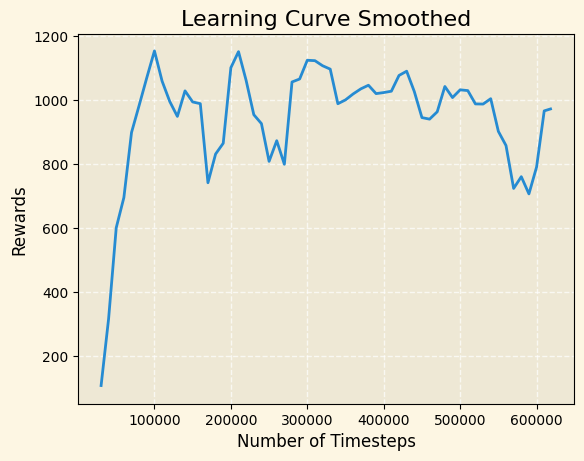

In [ ]:
from stable_baselines3.common import results_plotter

# Helper from the library
# results_plotter.plot_results(
#     [log_dir], 1e4, results_plotter.X_TIMESTEPS, "Attack Simulation"
# )
plot_results(log_dir)                                                                                             

In [ ]:
from stable_baselines3 import DQN

# Load the best model
best_model_path = "./gym/best_model"
# model = DQN.load(best_model_path)
n_episodes = 5  # Number of evaluation episodes
total_rewards = []
total_qoe = []
for episode in range(n_episodes):
    print(episode)
    obs, _ = env.reset(seed=4022+episode)
    done = False
    episode_reward = 0

    while not done:
        # Use the trained model to predict the action
        action, _ = model.predict(obs, deterministic=True)  # Use deterministic actions during evaluation
        obs, reward, done, truncated, info = env.step(action)
        episode_reward += reward

    total_rewards.append(episode_reward)
    total_qoe.append(info["mean_qoe"])
    print(f"Episode {episode + 1}: Total Reward = {episode_reward}")

# Calculate average reward over episodes
average_reward = sum(total_rewards) / n_episodes
print(f"Average Reward over {n_episodes} episodes: {average_reward}")
print(f"Average QoE over {n_episodes} episodes: {np.mean(total_qoe)}")
total_qoe

0
Episode 1: Total Reward = 1017.0400866921109
1
Episode 2: Total Reward = 1254.6413238510834
2
Episode 3: Total Reward = 1072.625212158259
3
Episode 4: Total Reward = 749.3335812543797
4
Episode 5: Total Reward = 696.723585863684
Average Reward over 5 episodes: 958.0727579639033
Average QoE over 5 episodes: 0.89582161776096


[0.9017092247090266,
 0.9254708337945314,
 0.9072733858752959,
 0.8749576049294818,
 0.8696970394964639]

Mean QoE 0.8561511899512506


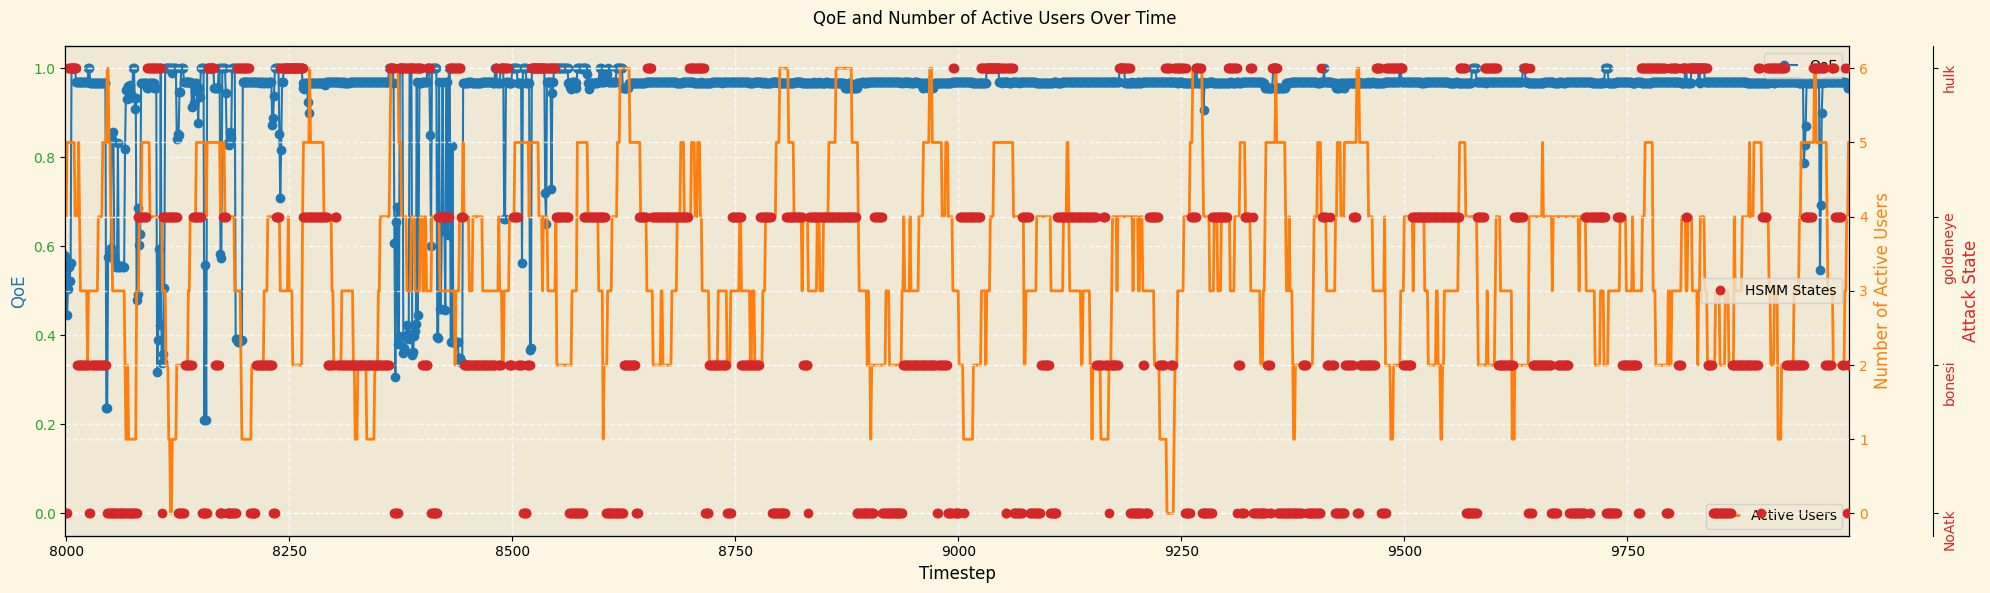

9999
Mean QoE 0.854929199578425


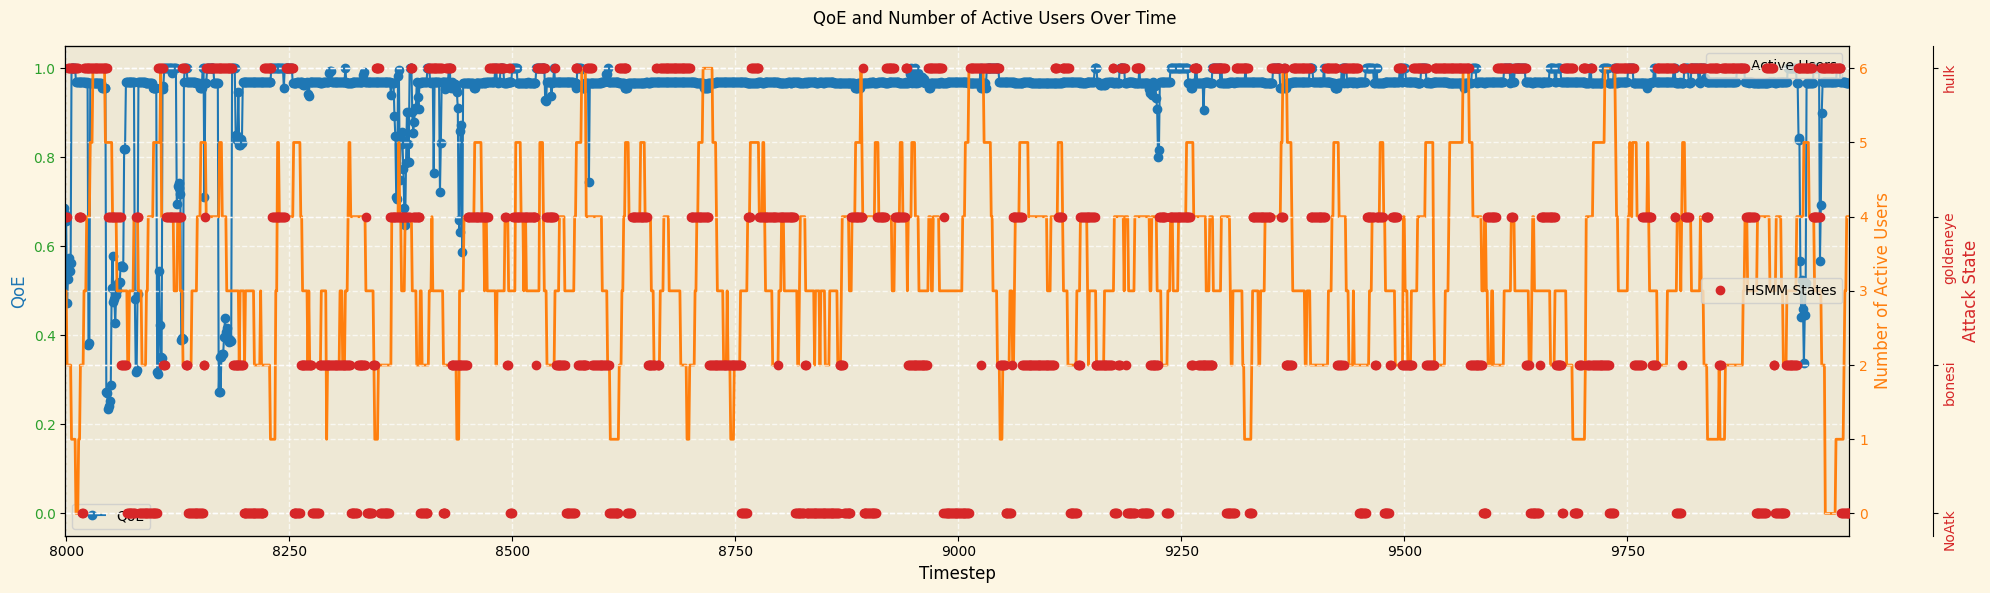

9999
Mean QoE 0.8980107289597162


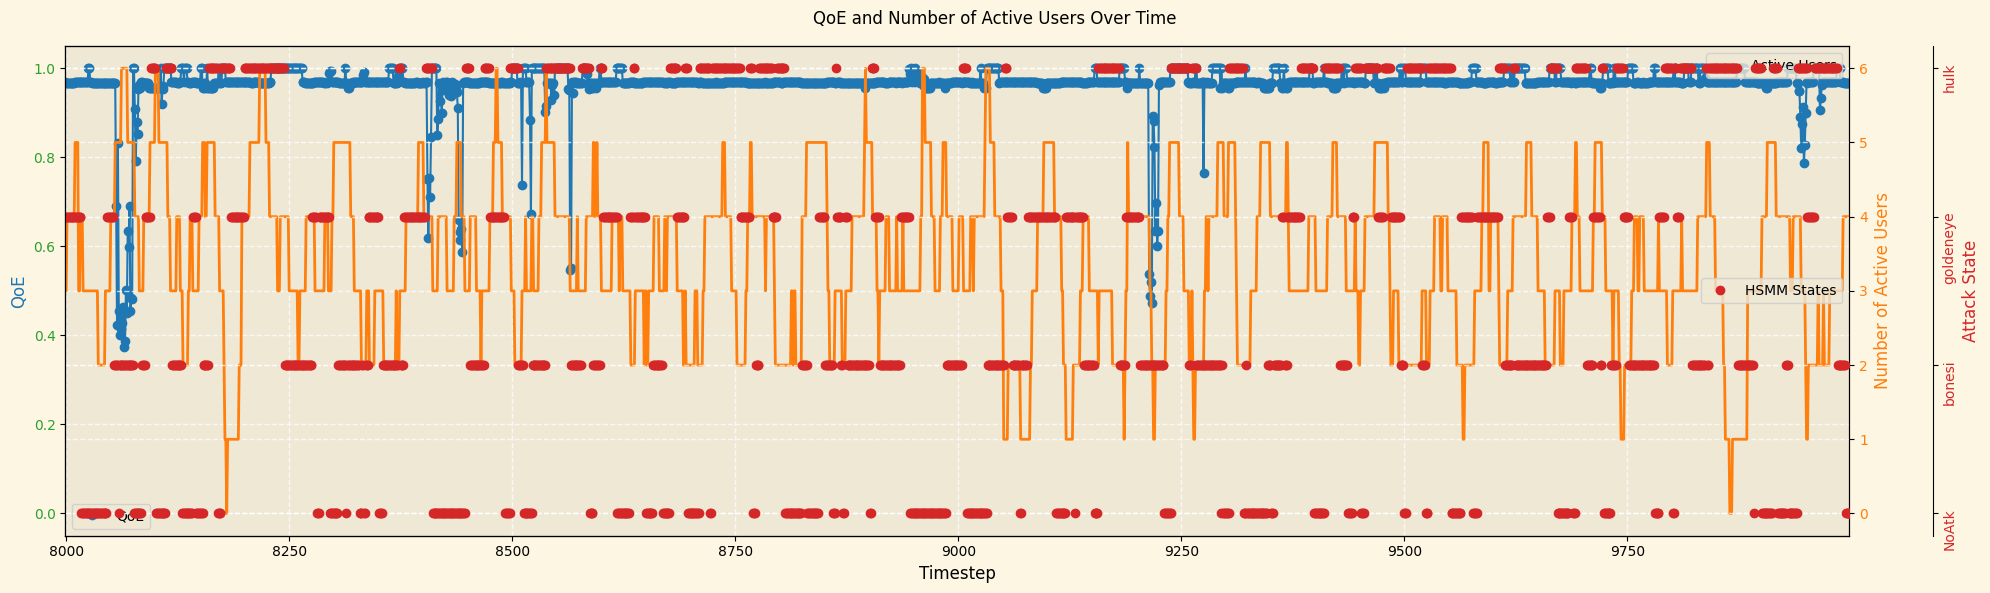

9999


In [ ]:
env.env.plot_qoe()

In [ ]:
np.mean(env.env.env.global_qoe_list)

0.7924742452460132

In [ ]:
env.env.global_qoe_list

AttributeError: 'QoEEnvironment' object has no attribute 'global_qoe_list'